# 🌿 PlantVillage CNN Classifier
Questo notebook esegue:
- Caricamento dei dati con `ImageDataGenerator`
- Addestramento CNN
- Valutazione delle metriche
- Visualizzazione dei risultati

Assicurati che la struttura delle cartelle sia corretta e che i moduli Python siano nella stessa directory.

In [ ]:
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image #per Eliminare Immagini non valide
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from utils import plot_class_distribution, plot_confusion_matrix
from evaluate import evaluate_model, plot_training


C:\Users\matte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def undersample_dataset(original_dir, output_dir, max_per_class=1000):
    os.makedirs(output_dir, exist_ok=True)
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(images)
        selected_images = images[:max_per_class]
        out_class_dir = os.path.join(output_dir, class_name)
        os.makedirs(out_class_dir, exist_ok=True)
        for img_name in selected_images:
            shutil.copy2(os.path.join(class_dir, img_name), os.path.join(out_class_dir, img_name))
    print(f"✅ Dataset bilanciato salvato in: {output_dir}")

undersample_dataset(
    original_dir="DataSet/PlantVillage",
    output_dir="DataSet/PlantVillage_Balanced",
    max_per_class=1000
)


✅ Dataset bilanciato salvato in: DataSet/PlantVillage_Balanced


In [3]:
def rimuovi_immagini_corrotte(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    img.verify()  # Verifica l'integrità
                except (IOError, SyntaxError):
                    print(f"🗑️ Immagine corrotta rimossa: {path}")
                    os.remove(path)

Found 16492 images belonging to 15 classes.


c:\Users\matte\Desktop\Progetti Unibo\2 Anno\2 Semestre\AI, Machine Learning\Progetto Classificazione Foglie Aloè_Strazzella\utils.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=30, ha='right')  # ruota le etichette per migliorare la leggibilità


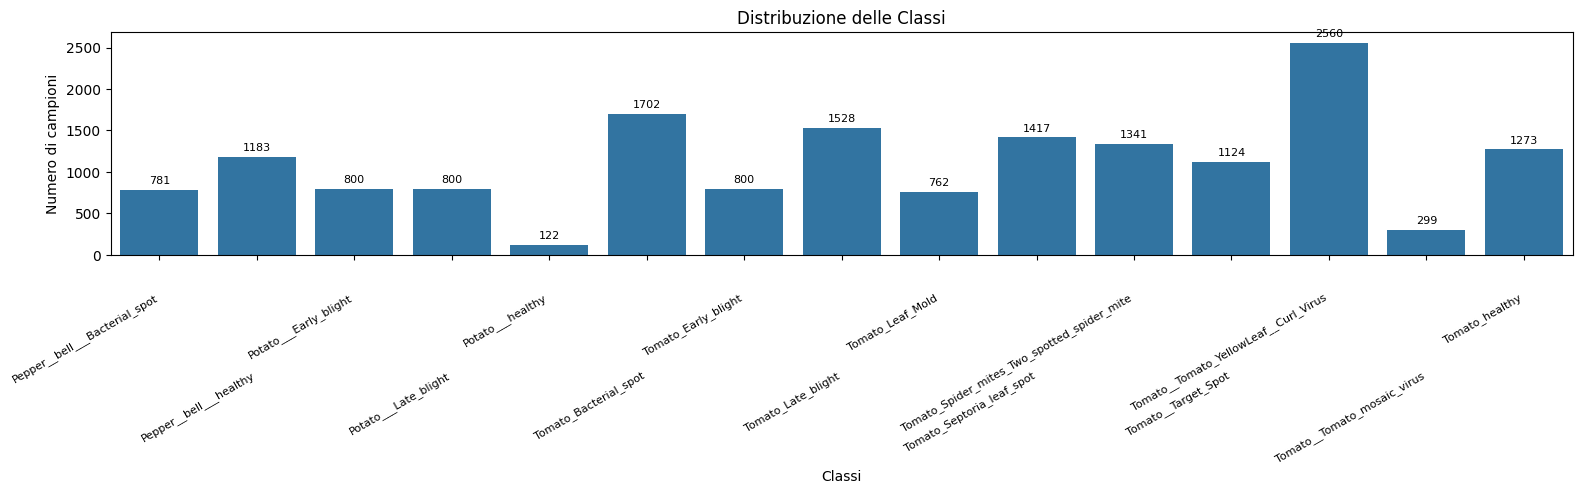

In [4]:
data_dir = "DataSet/PlantVillage_Balanced"
rimuovi_immagini_corrotte("DataSet/PlantVillage_Balanced")
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
plot_class_distribution(train_gen)


In [8]:
from model import create_cnn_model, create_transfer_model
from augmentation import get_data_augmentation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tqdm.keras import TqdmCallback

def train(data_dir, img_size=(64, 64), batch_size=32, epochs=10, use_transfer_learning=False):
    datagen = get_data_augmentation()

    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=42
    )

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=42
    )

    num_classes = train_generator.num_classes
    input_shape = img_size + (3,)

    model = create_transfer_model(input_shape, num_classes) if use_transfer_learning else create_cnn_model(input_shape, num_classes)

    callbacks = [
        ModelCheckpoint('saved_models/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        TqdmCallback(verbose=1)
    ]

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        steps_per_epoch=len(train_generator),
        validation_steps=len(val_generator),
        verbose=0
    )
    print("✅ train() chiamata con:", data_dir, img_size, batch_size, epochs, use_transfer_learning)

    return model, history, val_generator



In [9]:
model, history, val_generator = train(data_dir="DataSet/PlantVillage_Balanced")



Found 16492 images belonging to 15 classes.
Found 4116 images belonging to 15 classes.


C:\Users\matte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
0epoch [00:00, ?epoch/s]C:\Users\matte\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
100%|██████████| 10/10 [08:40<00:00, 52.08s/epoch, accuracy=0

✅ train() chiamata con: DataSet/PlantVillage_Balanced (64, 64) 32 10 False


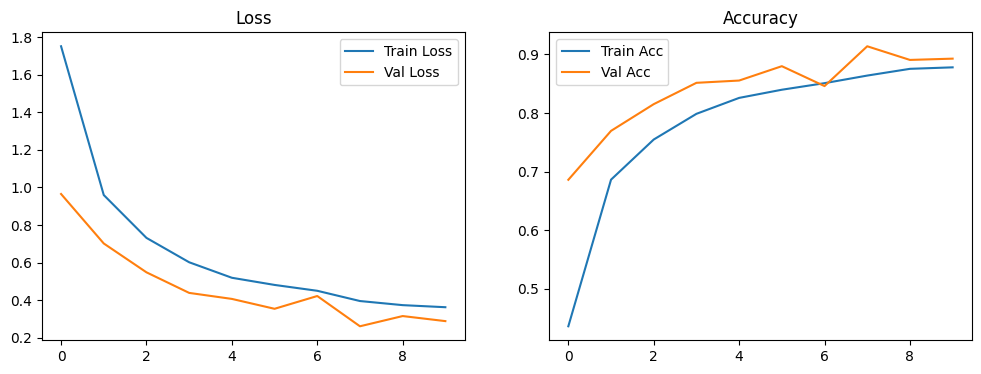

129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.05      0.05      0.05       195
                     Pepper__bell___healthy       0.06      0.06      0.06       295
                      Potato___Early_blight       0.02      0.02      0.02       200
                       Potato___Late_blight       0.04      0.06      0.05       200
                           Potato___healthy       0.00      0.00      0.00        30
                      Tomato_Bacterial_spot       0.11      0.12      0.11       425
                        Tomato_Early_blight       0.07      0.07      0.07       200
                         Tomato_Late_blight       0.09      0.09      0.09       381
                           Tomato_Leaf_Mold       0.06      0.06      0.06       190
                  Tomato_Septoria_leaf_spot       0.09      0.08      0.08       354
Tomato_Spider_mites_Tw

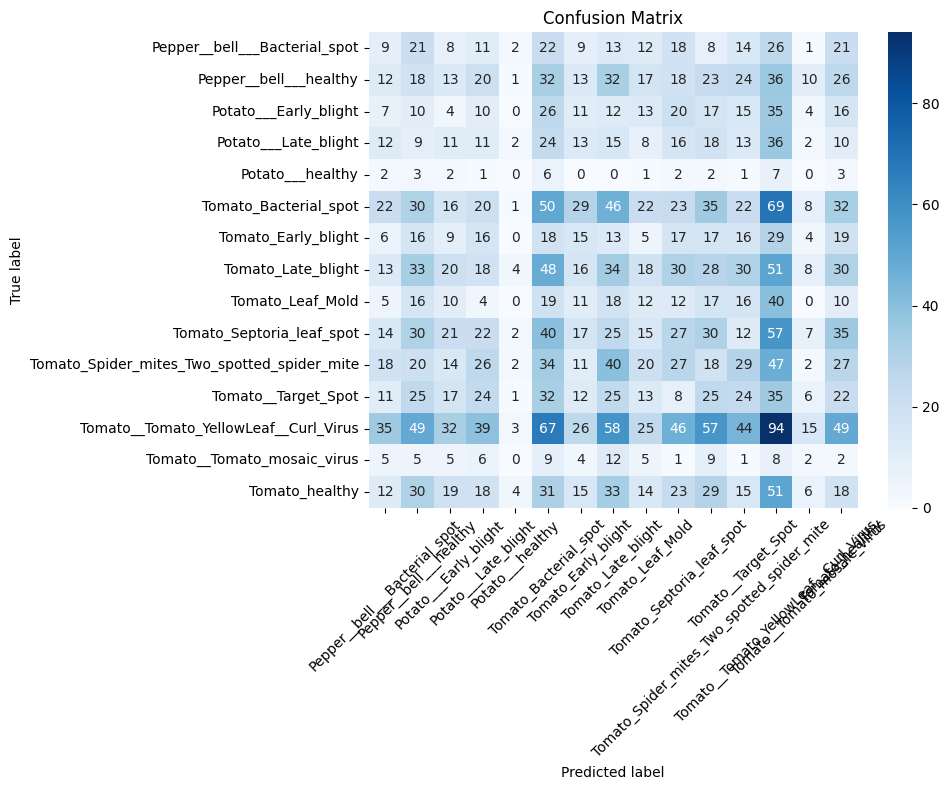

In [15]:
plot_training(history)
cm, class_labels = evaluate_model(model, val_generator)
plot_confusion_matrix(cm, class_labels)


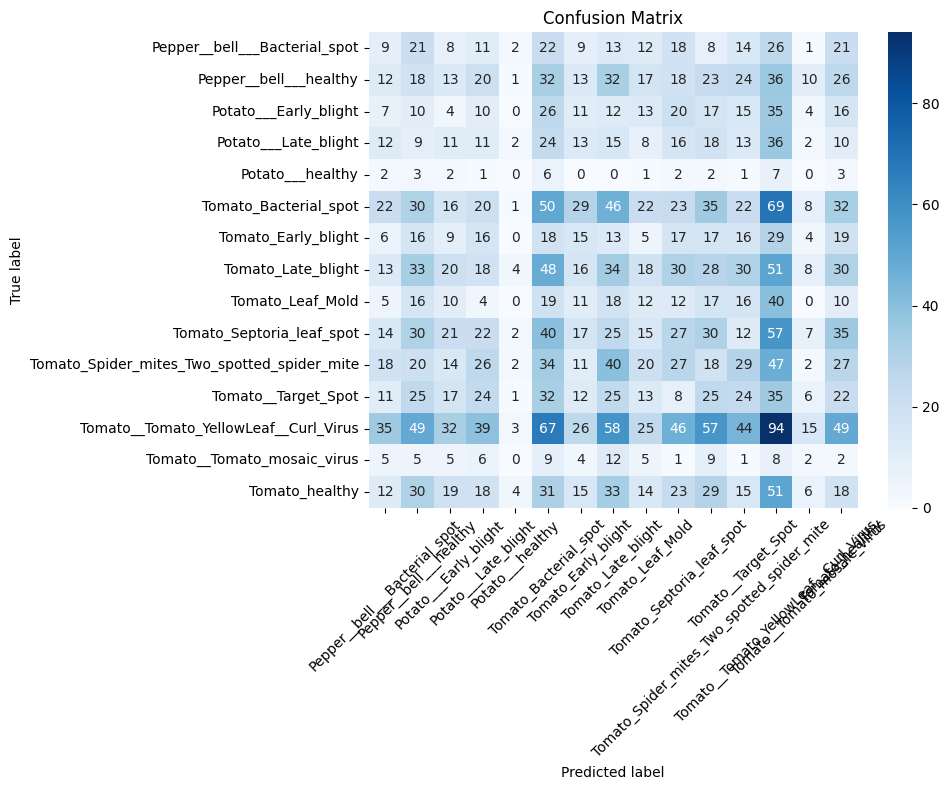

In [28]:
plot_confusion_matrix(cm, class_labels)